# Titanic Problem

## Dependencies 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap

## Data

In [2]:
dataset = pd.read_csv('train.csv')

df =  pd.DataFrame(dataset)
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
traindf = pd.get_dummies(df, columns=['Sex', 'Embarked'])
train_df = traindf.drop(columns= 'Sex_male')

train_df.head(5)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,0,0,1


## Train Test Split

In [4]:
X = train_df[['Pclass','Age', 'SibSp', 'Parch',
        'Fare','Sex_female', 'Embarked_C',
       'Embarked_Q', 'Embarked_S']]
y = train_df['Survived'].values.reshape(-1, 1)
print(X.shape, y.shape)

(891, 9) (891, 1)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Imputation 

In [6]:
from sklearn.impute import SimpleImputer
cols_with_missing_train = [col for col in X_train.columns
                     if X_train[col].isnull().any()]
cols_with_missing = [col for col in X_test.columns
                     if X_test[col].isnull().any()]

In [7]:
my_imputer = SimpleImputer()

X_train_plus = X_train.copy()
X_test_plus = X_test.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_test_plus[col + '_was_missing'] = X_test_plus[col].isnull()

# Imputation
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_test_plus = pd.DataFrame(my_imputer.transform(X_test_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_test_plus.columns = X_test_plus.columns

## Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(imputed_X_train_plus)
X_test = sc_X.fit_transform(imputed_X_test_plus)

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
y_pred = classifier.predict(X_test)

## Confustion Matrix

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [12]:
cm

array([[119,  20],
       [ 24,  60]], dtype=int64)

In [13]:
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error: " + str(mean_absolute_error(y_pred, y_test)))

Mean Absolute Error: 0.19730941704035873


## Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, random_state=897)
rf = rf.fit(X_train, y_train.ravel())
rf.score(X_test, y_test)

0.8340807174887892

## XGB Classifier

In [15]:
from xgboost import XGBClassifier

In [16]:
my_model = XGBClassifier(n_estimators=50, learning_rate=0.1)
my_model.fit(X_train, y_train,  
             early_stopping_rounds=5, 
             eval_set=[(X_test, y_test.ravel())],
             verbose=False)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [17]:
my_model.score(X_test, y_test)

0.820627802690583

## Shap Visualizations 

In [18]:
shap_values = shap.TreeExplainer(my_model).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [19]:
X_train_plus.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Age_was_missing'],
      dtype='object')

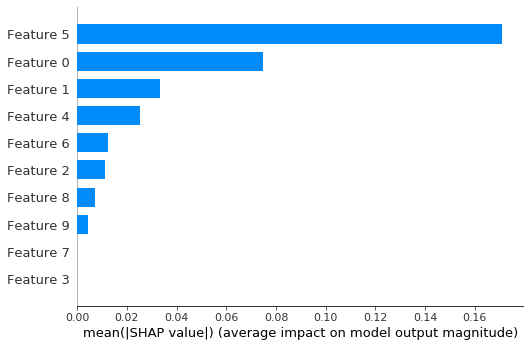

In [20]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

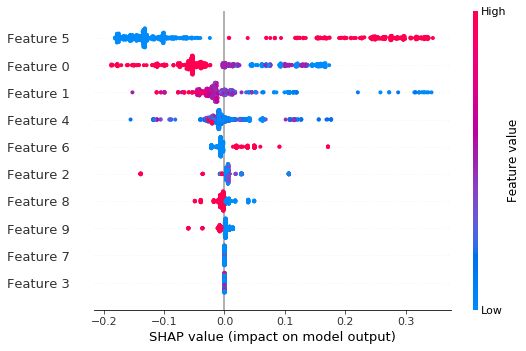

In [21]:
f = plt.figure()
shap.summary_plot(shap_values, X_train)